In [1]:
import pandas as pd 
import numpy as np
import copy
from datetime import datetime

In [2]:
import scipy
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_columns', 50)

В этом задании Вам необходимо предсказать **является ли абонент мультисимером** (имеет 2+ СИМ-карты). 


### Задание

Проведите преодобработку и анализ фичей, постройте модель бинарной классификации, оцените ее точность, обоснуйте выбор метрики и не забудьте сделать предсказания для абонентов, у которых поле **'target'** содержит значение **'NaN'**.

**1. Считайте датасет и проведите первичный анализ**

*Описание полей, как и сам датасет. доступны внутри файла multisim_dataset*

In [5]:
dfs = pd.read_excel('multisim_dataset.xlsx')
dfs.head()

id  mg_traffic_in  tp_code  num_voice_out tp_change_date  uniq_calls_cnt  \
0  101           2.98      1.0           17.0            NaT              53   
1  102           1.82      2.0           97.0            NaT              82   
2  103           0.00      3.0           22.0            NaT              58   
3  104           0.00      4.0           30.0            NaT              61   
4  105           0.80      5.0           29.0            NaT              49   

   age_cat  tech_sms_cnt_3m  tech_sms_cnt_6m  called_ctn_all_group  \
0        4            657.0           1917.0                   0.0   
1        5              0.0             22.0                   5.0   
2        3            162.0            246.0                   0.0   
3       10              NaN              NaN                   0.0   
4        0             66.0            130.0                   1.0   

   device_cost   traf_kb sim_type  gender_male_prob  complex_value_sum  \
0       4955.0   6233088  DualSim          0.908237       27287.666667   
1       6990.0  47462400  DualSim          0.871256       16611.000000   
2      13689.0         0  DualSim          0.928517       20658.000000   
3        490.0         0  DualSim          0.644491       18045.000000   
4      16051.0         0  DualSim          0.949505        9032.000000   

   complex_value_size  imei_cnt  main_balance_adjust_minus_cnt state_code  \
0            4.666667       1.0                            NaN        AST   
1            1.666667       1.0                            NaN        ORB   
2            1.000000       1.0                            NaN        VIP   
3            2.666667       1.0                            NaN        KCH   
4            1.000000       1.0                       1.333333        STV   

   macro_state  time_onnet  sum_recharges_3m  year  month  target  
0            1        3977            809.00  2019      1     NaN  
1            1        1617            622.00  2019      1     NaN  
2            1        2703            366.04  2019      1     1.0  
3            1        1153           1122.58  2019      1     1.0  
4            1        2174            633.20  2019      1     0.0

In [6]:
dfs.shape
# датасет имеет 90000 заисей и 25 полей включая target

(90000, 25)

In [7]:
# посмотрим какого типа поля
dfs.dtypes

id                                        int64
mg_traffic_in                           float64
tp_code                                 float64
num_voice_out                           float64
tp_change_date                   datetime64[ns]
uniq_calls_cnt                            int64
age_cat                                   int64
tech_sms_cnt_3m                         float64
tech_sms_cnt_6m                         float64
called_ctn_all_group                    float64
device_cost                             float64
traf_kb                                   int64
sim_type                                 object
gender_male_prob                        float64
complex_value_sum                       float64
complex_value_size                      float64
imei_cnt                                float64
main_balance_adjust_minus_cnt           float64
state_code                               object
macro_state                               int64
time_onnet                              

#### Data preprocessing

Данная таблица содержит 30 тысяч пользователей и данные за 3 месяца. Большая часть информации дублируется (за исключением поля mg_traffic_in), также есть вероятность ошибок. Данные были сгруппированы по Id  с использованием mean для агрегирования и далее в новый датафрейм взяты «свежие данные» за последний доступный месяц (это строки с 30000 до 60000)

In [8]:
g = dfs.groupby('id')
df_means = dfs.groupby('id').mean()
df_fresh = copy.deepcopy(dfs[30000:60000])

In [9]:
# индексация нового датафрейма
df_fresh.index = df_means.index

# для полей к которым было применимо mean перенос агрегированных значений
for columns in df_fresh.columns[2:-3]:
    if columns in df_means.columns:
        df_fresh[columns] = df_means[columns]

In [10]:
# проверка, что целевая переменная (также было проверенно для sim_type) в новом датафрейме равна "наиболее ожидаемому"
# для этого пользователя 
# допущение: если у пользователя в декабре и феврале тип карты Dual, а в январе Single, то это может быть ошибкой 
# и бралось наиболее «ожидаемое значение» 
target_list = []
for i in g.groups:
    if g.get_group(i)['target'].nunique() > 0:
        target_list.append(g.get_group(i)['target'].mode()[0])
    else:
        target_list.append(-1)     
print(df_fresh.target.value_counts())
print(np.unique(target_list, return_counts=True))

1.0    12675
0.0    12260
Name: target, dtype: int64
(array([-1.,  0.,  1.]), array([ 5065, 12260, 12675], dtype=int64))


In [11]:
# так как поле mg_traffic_in имеет в каждом месяце новые значения, то для результирующей таблицы созданы 3 поля 
# со значениями mg_traffic_in за каждый месяц.
mg_traffic_in_1 = dfs.iloc[:30000]['mg_traffic_in'].tolist()
mg_traffic_in_2 = dfs.iloc[30000:60000]['mg_traffic_in'].tolist()
mg_traffic_in_3 = dfs.iloc[60000:]['mg_traffic_in'].tolist()
len(mg_traffic_in_3) == len(mg_traffic_in_2) == len(mg_traffic_in_1)

# вставка полей
df_fresh.insert(1, 'mg_traffic_in_1', mg_traffic_in_1)
df_fresh.insert(2, 'mg_traffic_in_2', mg_traffic_in_2)
df_fresh.insert(3, 'mg_traffic_in_3', mg_traffic_in_3)
df_fresh.drop('mg_traffic_in', axis= 1, inplace= True)

# так как итоговая таблица содержит агрегированные данные за все месяцы, то поля год и месяц неинформативны 
df_fresh.drop(['month', 'year'], axis= 1, inplace= True)

In [12]:
# проверка доли различных значений в каждом поле 
df_fresh.nunique()/ len(df_fresh)

id                               1.000000
mg_traffic_in_1                  0.242600
mg_traffic_in_2                  0.243733
mg_traffic_in_3                  0.247467
tp_code                          0.061033
num_voice_out                    0.017867
tp_change_date                   0.055100
uniq_calls_cnt                   0.020067
age_cat                          0.000367
tech_sms_cnt_3m                  0.049233
tech_sms_cnt_6m                  0.084700
called_ctn_all_group             0.000900
device_cost                      0.030100
traf_kb                          0.289333
sim_type                         0.000067
gender_male_prob                 0.977833
complex_value_sum                0.763767
complex_value_size               0.001467
imei_cnt                         0.001000
main_balance_adjust_minus_cnt    0.013267
state_code                       0.002833
macro_state                      0.000067
time_onnet                       0.191700
sum_recharges_3m                 0

In [13]:
# поля 'id', 'gender_male_prob' неимформативны 
df_fresh.drop(['id', 'gender_male_prob'], axis=1, inplace= True)

In [14]:
# проверка доли пропущенных значений
df_fresh.isnull().sum() / len(df_fresh)

mg_traffic_in_1                  0.000000
mg_traffic_in_2                  0.000000
mg_traffic_in_3                  0.000000
tp_code                          0.000200
num_voice_out                    0.000000
tp_change_date                   0.000000
uniq_calls_cnt                   0.000000
age_cat                          0.000000
tech_sms_cnt_3m                  0.314500
tech_sms_cnt_6m                  0.314500
called_ctn_all_group             0.000933
device_cost                      0.021833
traf_kb                          0.000000
sim_type                         0.017267
complex_value_sum                0.000600
complex_value_size               0.000600
imei_cnt                         0.005667
main_balance_adjust_minus_cnt    0.667667
state_code                       0.000000
macro_state                      0.000000
time_onnet                       0.000000
sum_recharges_3m                 0.000000
target                           0.168833
dtype: float64

In [15]:
# поле main_balance_adjust_minus_cnt содержет более 60% отсутствующих значений и его можно удалить 
df_fresh.drop('main_balance_adjust_minus_cnt', axis= 1, inplace= True)

In [16]:
# поля sim_type и state_code имели тип object. Перекодируем значения в целочисленные значения
df_fresh.sim_type.replace(to_replace=dict(MonoSim=1, DualSim=2), inplace=True)
le = preprocessing.LabelEncoder()
df_fresh['state_code'] = le.fit_transform(df_fresh['state_code'])

In [17]:
# для поля tp_change_date заменим дату на количество дней с данной даты 
df_fresh['tp_change_date'] = df_fresh['tp_change_date'].apply(lambda x: (datetime.today() - x).days)

In [18]:
# заполнение пропущенных значений на среднее по полю или на -1
df_fresh.tp_code = df_fresh.tp_code.fillna(df_fresh.tp_code.mode().iloc[0])
df_fresh.called_ctn_all_group = df_fresh.called_ctn_all_group.fillna(df_fresh.called_ctn_all_group.mode().iloc[0])
df_fresh.imei_cnt = df_fresh.imei_cnt.fillna(df_fresh.imei_cnt.mode().iloc[0])
df_fresh.tech_sms_cnt_3m.fillna(-1, inplace= True)
df_fresh.tech_sms_cnt_6m.fillna(-1, inplace= True)
df_fresh.device_cost.fillna(-1, inplace= True)
df_fresh.complex_value_sum.fillna(-1, inplace= True)
df_fresh.complex_value_size.fillna(-1, inplace= True)
df_fresh.sim_type.fillna(0, inplace= True)

**2. Постройте простейшую модель (*baseline*) и сделайте выводы**

*Можно использовать любые модели*

In [24]:
# разделим датасет на набор где target известен и будем его использовать для обучения
df_model = df_fresh[df_fresh.target.notnull()]
df_test = df_fresh[df_fresh.target.isnull()]

X = df_model.drop('target', axis= 1)
y = df_model['target']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

In [25]:
# используем dummy классификатор
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.509324243031883

Точность классификатора - 0.5, это означает что целевая переменная имеет примерно одинаковое количество примеров в обоих классах.

In [26]:
# график для target
sns.countplot(x='target',data=df_model)

Так как классы взвешанны, то для оценки можно будет использовать accuracy.

**3. Визуализируйте значения фичей в зависимости от таргета или других фич**

*Интерпретируйте полученные результаты*

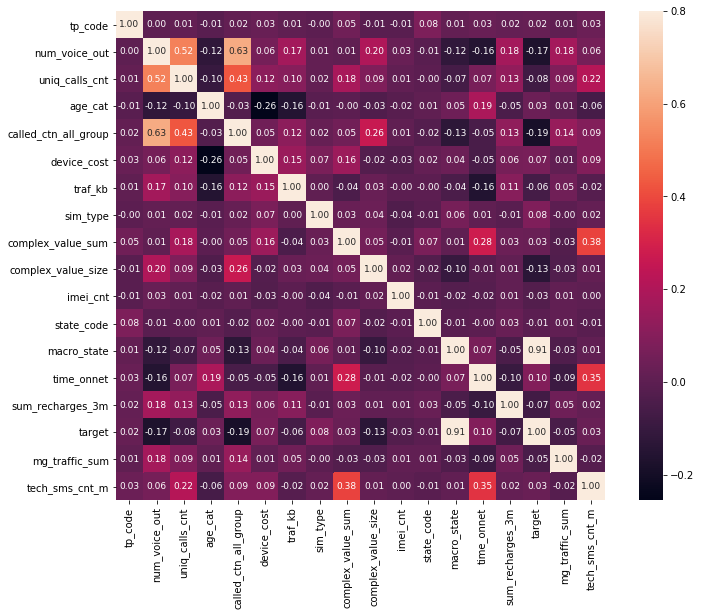

In [27]:
# матрица корреляции 
corr_mat = df_fresh.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True, annot= True, fmt='.2f', annot_kws={'size': 9});

Именно в данном Dataset целевая переменная имеет очень сильную зависимость от macro_state (к-т кор-ии 0.91) и практически не зависит от отсальных переменных. ? т.е.практически однозначно можно определить значение target по macro_state.

**4. Постройте модель с учетом прошлых пунктов**

Я выбрала 2 модели - построить случайный лес для всего Dataset и метод опорных векторов для модели по одному признаку (macro_state)

In [28]:
sc = StandardScaler()
X = df_model.drop('target', axis= 1)
y = df_model['target']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)
X_train_sc = sc.fit_transform(X_train)

X_train_one, X_test_one, y_train_one, y_test_one= train_test_split(X[['macro_state']], y, test_size=0.2)
X_train_one_sc = sc.fit_transform(X_train_one)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


*Не забудьте про валидацию и оптимизацию гиперпараметров*

In [29]:
# RandomForest
parameters = [{
    'max_depth': range(1,5),
    "n_estimators": [10, 20, 40, 60],
}]
rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
rf_model = rf.best_estimator_
y_rf = rf_model.predict(X_test)
print("Random forest: best score- {}, best params- {}".format(rf.best_score_, rf.best_params_))
print("Test set acc: ", rf_model.score(X_test, y_test))

Random forest: best score- 0.9538800882293964, best params- {'max_depth': 1, 'n_estimators': 40}
Test set acc:  0.9510727892520553


In [30]:
# Support vector machine
parameters = {'C': [0.01, 0.1, 1], 
              'kernel': ['linear']}
alg_svm = GridSearchCV(SVC(), parameters, cv=5, n_jobs=-1)
alg_svm.fit(X_train_one, y_train_one)
svm_model = alg_svm.best_estimator_
print("SVM: best score- {}, best params- {}".format(alg_svm.best_score_, alg_svm.best_params_))
print("Test set acc: ", svm_model.score(X_test_one, y_test_one))

SVM: best score- 0.9525766994184881, best params- {'kernel': 'linear', 'C': 0.01}
Test set acc:  0.9562863444956888


Для леса получено, что лучшая глубина равна 1, а это означает, что только одного признака достаточно для предсказания. 
Идея спользовать только один признак в Support vector machine с линейным ядром на тестовом наборе показала результат даже лучше, чем случайный лес. 

**5. Сделайте предсказания и выведите значения метрик (самостоятельно написав основные функции, например, через confusion matrix)**

In [31]:
cnf_matrix = confusion_matrix(y_test, y_rf)

In [32]:
def accuracy(cnf_matrix):
    return (cnf_matrix[0][0] + cnf_matrix[1][1])/cnf_matrix.sum()

def recall(cnf_matrix):
    tn, fp, fn, tp = cnf_matrix.ravel()
    return tp/(tp + fn)

def precision(cnf_matrix):
    tn, fp, fn, tp = cnf_matrix.ravel()
    return tp/(tp + fp)

def f1(cnf_matrix):
    tn, fp, fn, tp = cnf_matrix.ravel()
    return 2*tp/(2*tp + fp + fn)


In [33]:
print("Accuracy: ", accuracy(cnf_matrix))
print("Recall: ", recall(cnf_matrix))
print("Precision: ", precision(cnf_matrix))
print("F1: ", f1(cnf_matrix))

Accuracy:  0.9510727892520553
Recall:  0.9054996127033308
Precision:  1.0
F1:  0.9504065040650407


In [34]:
# Предсказание для данных с target = null
df_test.drop('target', axis= 1, inplace= True)
X_sc = sc.fit_transform(df_test)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [35]:
y_out_rf = rf_model.predict(X_sc)
np.unique(y_out_rf, return_counts=True)

(array([0.]), array([5065], dtype=int64))

In [36]:
y_out_svc = svm_model.predict(df_test[['macro_state']])
np.unique(y_out_svc, return_counts=True)

(array([0.]), array([5065], dtype=int64))

Для всех пользователей предсказано значение целевой переменной равное 0

**6. Опишите следующие шаги, которые Вы бы решили делать в следующих итерациях проекта**

Более детально исследовать пользователей для которых для которых был неверно определен класс. Модель, которая предсказывала результат по одному признаку фактически работает по правилу (если macro_state = 2, то target = 1, если macro_state = 1, то target = 0) и можно было без моделей и использовать одно решающее правило.

Всего для 1164 пользователей macro_state = 1 и target = 1. Для этой группы можно найти признаки, которые наиболее сильно влияют на целевую переменную и добавить их к модели.


### Задание (бонус)

Пара задачек по Python.

**1. Forward & backward**

In [39]:
np.random.seed(42)
w, X, y = np.random.random(10), np.random.random((11, 10)), 2 * (np.random.randint(0, 2, 11) - 0.5)

Формулы для логистической регрессии :)

Реализуйте линейную функцию

$$h_w(X) = \sigma(X w),$$
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In [40]:
def sigmoid(X, w):
    """ Функция, вычисляющая h(X, w)
    X - матрица (n, m)
    w - вектор (m,)
    """
    return 1 / (1 + np.exp(-X@w))

А также функцию потерь 

$$J(w)  = \frac{1}{m} \left(-y^T \text{log}(h_w) - (1-y)^T \text{log}(1 - h_w)\right)$$

и ее градиент

$$\frac{\partial J(w)}{\partial w}$$.

In [41]:
def loss(X, w, y):
    """ Функция потерь
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    return 1/w.shape[0] * y[np.newaxis, :]@np.log(sigmoid(X, w)) - (1-y[np.newaxis, :])@np.log(sigmoid(X, w))


def grad(X, w, y):
    """ Градиент функции потерь по w
    X - матрица (n, m)
    w - вектор (m,)
    y - вектор (n,)
    """
    
    gradient = X.T@(sigmoid(X,w) - y)
    return gradient/len(X)


print('loss = ', loss(X, w, y))
print('gradient = ', grad(X, w, y))

grad(X, w, y).shape == w.shape

loss =  [1.5482749]
gradient =  [0.59410185 0.61364804 0.45297435 0.69319396 0.67574935 0.70184535
 0.51226393 0.53179693 0.44832147 0.21803645]


True

**2. Lists** 

Напишите функцию, которая принимает список чисел mylist, число  $n$ и число $t$  и возвращает сумму $t$ наибольших чисел среди всех чисел списка меньше либо равных  $n$ .

Вариант 1: сложность = max(O(k), где k - длина mylist, O(t*logt), t - длина выходного списка)

In [42]:
def listnt(mylist, n, t):
    shortlist = []
    for el in mylist:
        if el <= n:
            shortlist.append(el)  
    return sum(sorted(shortlist,reverse=True)[:t])

Вариант 2: выходной список заполняется и сортируется на лету (экономия по памяти)
сложность = O(nt^2), в худшем случае, т.е. если входной список отсортирован в обратном порядке

In [43]:
def listnt(mylist, n, t):
    lst = []
    lst.append(mylist[0])
    min_el = -1
    for el in mylist:
        if el <=n:
            for i, k in enumerate(lst):
                if k<el:
                    lst.insert(i, el)
                    if len(lst)> t:
                        lst.pop()
                    break
    return sum(lst)

In [44]:
listnt([1, 2, 3, 4, 5, 6, 3, 7], 7, 8) == 31

True

In [45]:
listnt([1, 5, 3, 6, 5, 6, 3, 6], 6, 3) == 18

True

In [46]:
listnt([1, 5, 3, 6, 5, 6, 3, 6], 4, 2) == 6

True

In [47]:
listnt([1, 5, 3, 6, 5, 6, 3, 6], 6, 2) == 12

True

**3. Prime nums**

Напишите выражение, возвращающее все простые числа не больше заданного числа

In [48]:
# решето эратосфена
def prime(n):
    num = np.arange(2, n)
    prime_num = []
    for i, el in enumerate(num):
        if el!= 0:
            prime_num.append(el)
            for j in range(i, n-2, el):
                num[j] = 0
    
    return prime_num

In [49]:
prime(10) == [2, 3, 5, 7]

True

In [50]:
prime(21) == [2, 3, 5, 7, 11, 13, 17, 19]

True

In [51]:
prime(100) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97 ]

True